## RegNet-based CNN for Image Sentiment Classification

This Jupyter Interactive Script trains a small, custom RegNet-like convolutional neural network
on a binary sentiment dataset (Good = positive, Gore = negative) stored at:

`/kaggle/input/...`

The dataset originally used to develop this notebook (images with
binary sentiment labels "Good" / "Gore") is **not included** and
**will not be distributed** together with this notebook due to:

- legal and platform policy requirements regarding violent / shocking content,
- safety considerations and the intent to avoid redistributing harmful material.

To run this notebook you must provide your **own dataset** with an
equivalent structure.

Expected structure:

- `/kaggle/input/.../labels.txt`  (CSV: `filename,label`)
- `/kaggle/input/.../convert/`    (images referenced in `labels.txt`)

The model:
- is built from scratch (RegNet-style bottleneck blocks with group convolutions),
- uses Squeeze-and-Excitation (SE) and DropPath as modern additions,
- is trained with BCEWithLogitsLoss for binary classification.

In [1]:
import os
import random
import math
import time

import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)

Torch version: 2.6.0+cu124


## 1. Configuration and Reproducibility

In [2]:
# Paths (change if your dataset structure is different)
DATA_ROOT = "/kaggle/input/positiveness-dataset"
LABELS_PATH = os.path.join(DATA_ROOT, "labels.txt")
IMAGES_DIR = os.path.join(DATA_ROOT, "convert")

# Training hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_STATE)

Using device: cuda


## 2. Dataset & Dataloaders

We read `labels.txt` (format: `filename,label`), split into train/validation,
and define `SentimentImageDataset` that returns `(image_tensor, label_float)` pairs.

In [3]:
# Inspect data root
print("DATA_ROOT contents:", os.listdir(DATA_ROOT))

# Load labels
labels_df = pd.read_csv(LABELS_PATH, header=None, names=["filename", "label"])
labels_df["label"] = labels_df["label"].astype(int)

print("Number of samples:", len(labels_df))
print(labels_df["label"].value_counts())

labels_df.head()

DATA_ROOT contents: ['__results__.html', 'labels.txt', '__notebook__.ipynb', '__output__.json', 'convert', 'custom.css']
Number of samples: 10718
label
1    9012
0    1706
Name: count, dtype: int64


,filename,label
0,sentiment_good_1.jpg,1
1,sentiment_good_2.jpg,1
2,sentiment_good_3.jpg,1
3,sentiment_good_4.jpg,1
4,sentiment_good_5.jpg,1


In [4]:
# Train/validation split (stratified by label)
train_df, val_df = train_test_split(
    labels_df,
    test_size=VALIDATION_SPLIT,
    stratify=labels_df["label"],
    random_state=RANDOM_STATE,
)

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")
print("Train label distribution:\n", train_df["label"].value_counts())
print("Val label distribution:\n", val_df["label"].value_counts())

Train samples: 8574, Val samples: 2144
Train label distribution:
 label
1    7209
0    1365
Name: count, dtype: int64
Val label distribution:
 label
1    1803
0     341
Name: count, dtype: int64


In [5]:
# Transforms (ImageNet-style normalization)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.1)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


class SentimentImageDataset(Dataset):
    def __init__(self, df, images_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = float(row["label"])
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


train_dataset = SentimentImageDataset(train_df, IMAGES_DIR, transform=train_transform)
val_dataset = SentimentImageDataset(val_df, IMAGES_DIR, transform=val_transform)

pin_memory = device.type == "cuda"

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=pin_memory,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=pin_memory,
)

len(train_loader), len(val_loader)

(536, 134)

## 3. Model: Small RegNet-like CNN

- RegNet-style bottleneck blocks with grouped 3×3 convolutions
- Squeeze-and-Excitation (SE) for channel attention
- DropPath for regularization
- SiLU activations

In [6]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_ch: int, reduction: int = 4):
        super().__init__()
        reduced_ch = max(1, in_ch // reduction)
        self.fc1 = nn.Conv2d(in_ch, reduced_ch, kernel_size=1)
        self.fc2 = nn.Conv2d(reduced_ch, in_ch, kernel_size=1)
        self.act = nn.SiLU(inplace=True)
        self.gate = nn.Sigmoid()

    def forward(self, x):
        scale = F.adaptive_avg_pool2d(x, 1)
        scale = self.fc1(scale)
        scale = self.act(scale)
        scale = self.fc2(scale)
        scale = self.gate(scale)
        return x * scale


class DropPath(nn.Module):
    """Stochastic Depth (DropPath)"""
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x / keep_prob * random_tensor


class RegNetBottleneck(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        stride: int = 1,
        group_width: int = 16,
        bottleneck_ratio: float = 4.0,
        se_reduction: int = 4,
        drop_path_prob: float = 0.0,
    ):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride

        # RegNet-style width & groups
        width = int(round(out_ch / bottleneck_ratio))
        width = max(group_width, int(round(width / group_width) * group_width))
        groups = max(1, width // group_width)

        self.conv1 = nn.Conv2d(in_ch, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(
            width,
            width,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=groups,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_ch, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_ch)

        self.se = SqueezeExcitation(out_ch, reduction=se_reduction)
        self.act = nn.SiLU(inplace=True)

        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.downsample = None

        self.drop_path = DropPath(drop_path_prob)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = identity + self.drop_path(out)
        out = self.act(out)
        return out


class RegNetSmall(nn.Module):
    """
    Small RegNet-like model:
    - Stem: 3x3 conv, max-pool
    - 4 stages with RegNetBottleneck blocks
    - Global avg-pool + linear head
    """
    def __init__(
        self,
        num_classes: int = 1,
        depths=(1, 2, 4, 1),
        widths=(32, 64, 128, 256),
        group_width: int = 16,
        bottleneck_ratio: float = 4.0,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()

        assert len(depths) == len(widths), "depths and widths must have same length"

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        in_ch = 32
        stages = []
        total_blocks = sum(depths)
        block_idx = 0

        # Build stages
        for stage_idx, (depth, width) in enumerate(zip(depths, widths)):
            blocks = []
            for i in range(depth):
                stride = 2 if (stage_idx > 0 and i == 0) else 1
                drop_prob = drop_path_rate * block_idx / max(1, total_blocks - 1)
                blocks.append(
                    RegNetBottleneck(
                        in_ch=in_ch,
                        out_ch=width,
                        stride=stride,
                        group_width=group_width,
                        bottleneck_ratio=bottleneck_ratio,
                        se_reduction=4,
                        drop_path_prob=drop_prob,
                    )
                )
                in_ch = width
                block_idx += 1
            stages.append(nn.Sequential(*blocks))

        self.stages = nn.Sequential(*stages)

        # Head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_ch, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.pool(x)
        x = self.stages(x)
        x = self.head(x)
        # output shape: (batch, 1) for BCEWithLogitsLoss
        return x.view(x.size(0), -1)

In [7]:
# Instantiate model
model = RegNetSmall(
    num_classes=1,
    depths=(2, 3, 6, 2),
    widths=(64, 96, 160, 272),
    group_width=16,
    bottleneck_ratio=4.0,
    drop_path_rate=0.1,
)

model = model.to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params / 1e6:.2f}M")

RegNetSmall(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): Sequential(
    (0): Sequential(
      (0): RegNetBottleneck(
        (conv1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SqueezeExcitation(
          (fc1): Conv2d(64, 

## 4. Training Utilities

We use:
- `BCEWithLogitsLoss` (binary classification with logits)
- AdamW optimizer
- CosineAnnealingLR scheduler

Metrics:
- Loss
- Accuracy
- ROC AUC

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_probs = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # (N, 1)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        all_probs.extend(probs.tolist())
        all_targets.extend(labels.cpu().numpy().ravel().tolist())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds = (np.array(all_probs) >= 0.5).astype(np.int32)
    acc = accuracy_score(all_targets, preds)
    if len(np.unique(all_targets)) > 1:
        auc = roc_auc_score(all_targets, all_probs)
    else:
        auc = float("nan")
    return epoch_loss, acc, auc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_probs = []

    with torch.inference_mode():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # (N, 1)

            logits = model(images)
            loss = criterion(logits, labels)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
            all_probs.extend(probs.tolist())
            all_targets.extend(labels.cpu().numpy().ravel().tolist())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds = (np.array(all_probs) >= 0.5).astype(np.int32)
    acc = accuracy_score(all_targets, preds)
    if len(np.unique(all_targets)) > 1:
        auc = roc_auc_score(all_targets, all_probs)
    else:
        auc = float("nan")
    return epoch_loss, acc, auc, np.array(all_targets), np.array(all_probs)

## 5. Training Loop

In [9]:
history = {
    "train_loss": [],
    "train_acc": [],
    "train_auc": [],
    "val_loss": [],
    "val_acc": [],
    "val_auc": [],
}

best_val_auc = -np.inf
best_model_path = "/kaggle/working/regnet_sentiment_best.pth"

start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc, train_auc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc, val_auc, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_auc"].append(train_auc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_auc"].append(val_auc)

    print(
        f"Train  - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}"
    )
    print(
        f"Val    - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}"
    )

    # Save best model by validation AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> New best model saved (AUC={best_val_auc:.4f})")

total_time = (time.time() - start_time) / 60
print(f"\nTraining finished in {total_time:.1f} minutes.")
print("Best Val AUC:", best_val_auc)


Epoch 1/100
Train  - Loss: 0.2646, Acc: 0.8955, AUC: 0.9028
Val    - Loss: 0.1469, Acc: 0.9454, AUC: 0.9789
  -> New best model saved (AUC=0.9789)

Epoch 2/100
Train  - Loss: 0.1745, Acc: 0.9339, AUC: 0.9596
Val    - Loss: 0.1056, Acc: 0.9669, AUC: 0.9851
  -> New best model saved (AUC=0.9851)

Epoch 3/100
Train  - Loss: 0.1580, Acc: 0.9394, AUC: 0.9661
Val    - Loss: 0.0969, Acc: 0.9660, AUC: 0.9864
  -> New best model saved (AUC=0.9864)

Epoch 4/100
Train  - Loss: 0.1478, Acc: 0.9452, AUC: 0.9717
Val    - Loss: 0.1366, Acc: 0.9515, AUC: 0.9824

Epoch 5/100
Train  - Loss: 0.1344, Acc: 0.9524, AUC: 0.9752
Val    - Loss: 0.0901, Acc: 0.9683, AUC: 0.9883
  -> New best model saved (AUC=0.9883)

Epoch 6/100
Train  - Loss: 0.1172, Acc: 0.9554, AUC: 0.9813
Val    - Loss: 0.0958, Acc: 0.9688, AUC: 0.9857

Epoch 7/100
Train  - Loss: 0.1178, Acc: 0.9559, AUC: 0.9812
Val    - Loss: 0.1072, Acc: 0.9641, AUC: 0.9845

Epoch 8/100
Train  - Loss: 0.1097, Acc: 0.9602, AUC: 0.9833
Val    - Loss: 0.064

## 6. Training Curves

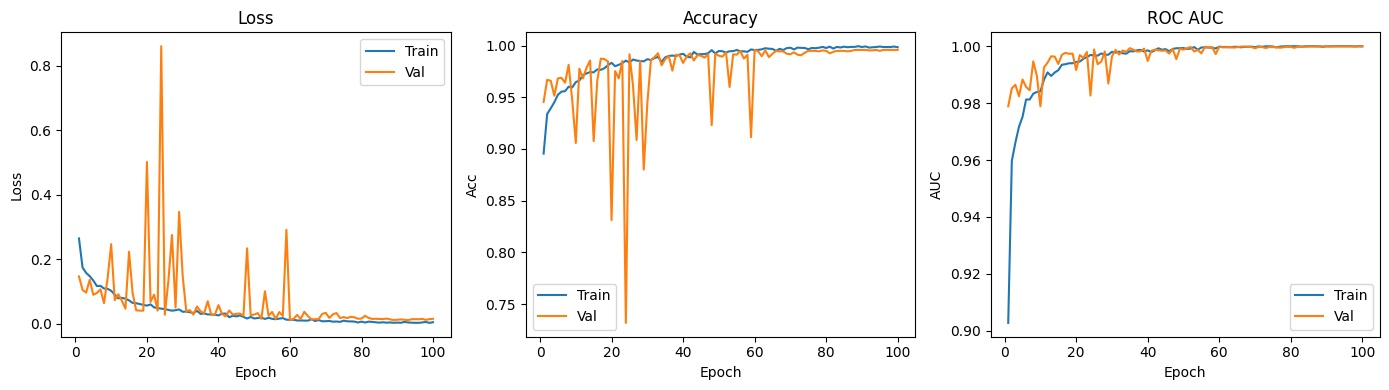

In [10]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"], label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_acc"], label="Train")
plt.plot(epochs, history["val_acc"], label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, history["train_auc"], label="Train")
plt.plot(epochs, history["val_auc"], label="Val")
plt.title("ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluation on Validation Set

We load the best model (by validation AUC), compute metrics,
and show a confusion matrix and classification report.

In [11]:
# Reload best model
best_model = RegNetSmall(
    num_classes=1,
    depths=(2, 3, 6, 2),
    widths=(64, 96, 160, 272),
    group_width=16,
    bottleneck_ratio=4.0,
    drop_path_rate=0.0,  # DropPath only used during training
).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

val_loss, val_acc, val_auc, val_targets, val_probs = evaluate(
    best_model, val_loader, criterion, device
)

val_preds = (val_probs >= 0.5).astype(int)

print(f"Best model - Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

cm = confusion_matrix(val_targets, val_preds)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(val_targets, val_preds, target_names=["Gore (0)", "Good (1)"]))

Best model - Val Loss: 0.0129, Acc: 0.9958, AUC: 0.9999

Confusion Matrix:
 [[ 333    8]
 [   1 1802]]

Classification Report:
              precision    recall  f1-score   support

    Gore (0)       1.00      0.98      0.99       341
    Good (1)       1.00      1.00      1.00      1803

    accuracy                           1.00      2144
   macro avg       1.00      0.99      0.99      2144
weighted avg       1.00      1.00      1.00      2144



## 8. Qualitative Inspection: Sample Predictions

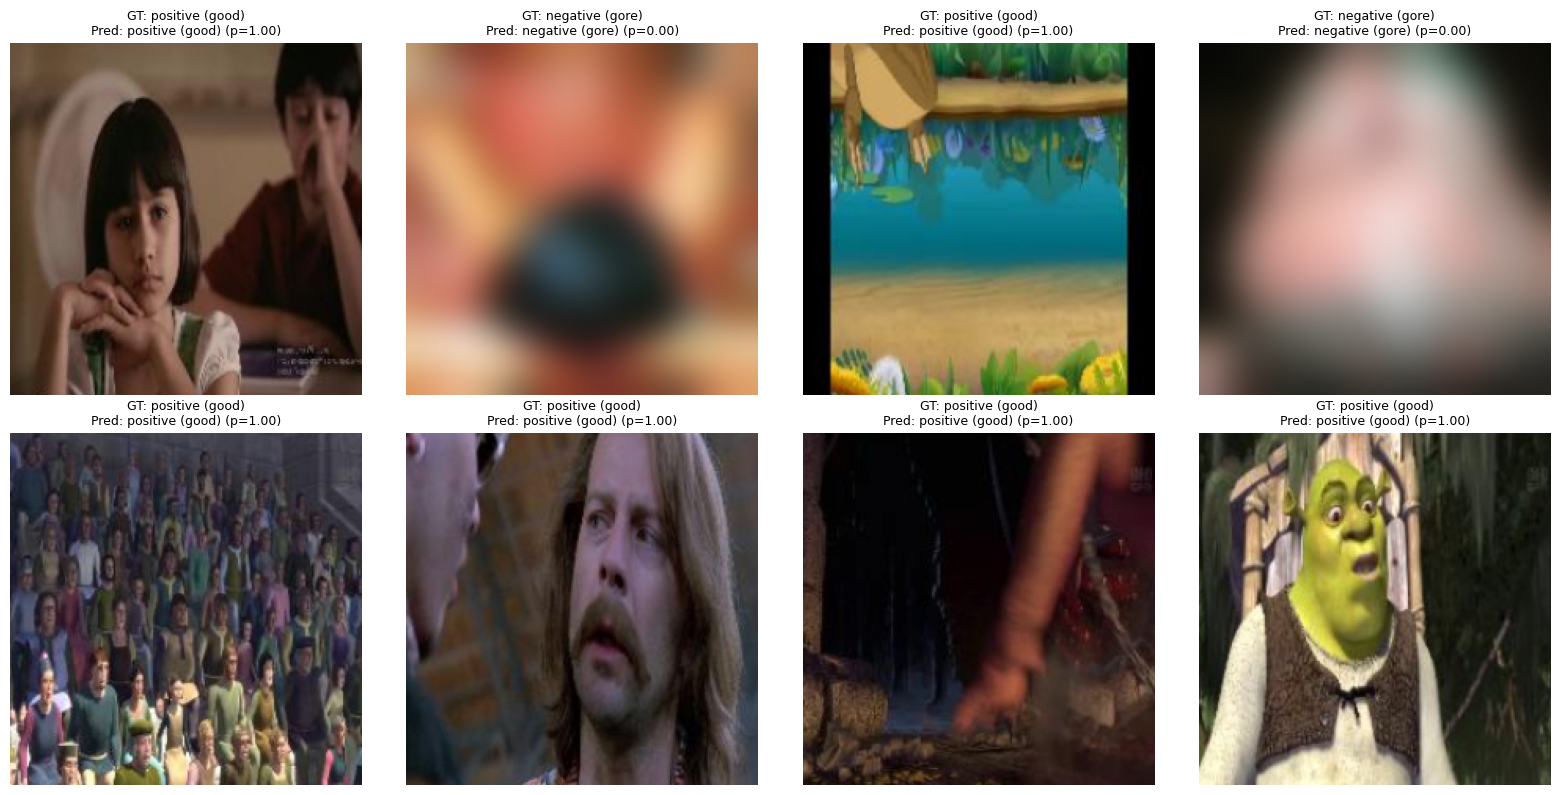

In [12]:
id2label = {0: "negative (gore)", 1: "positive (good)"}

def show_predictions(model, dataset, num_samples=8, blur_gore=True, blur_radius=12):
    model.eval()
    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    n_cols = 4
    n_rows = int(math.ceil(len(indices) / n_cols))
    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    with torch.inference_mode():
        for i, idx in enumerate(indices, 1):
            image, label = dataset[idx]      # image: tensor (C,H,W), label: 0/1
            logits = model(image.unsqueeze(0).to(device))
            prob = torch.sigmoid(logits).cpu().item()
            pred_label = int(prob >= 0.5)

            # Tensor convert
            img_np = image.clone().cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = (img_np * std + mean).clip(0, 1)
            img_uint8 = (img_np * 255).astype(np.uint8)
            img_pil = Image.fromarray(img_uint8)

            # Blur gore content
            is_gore = int(label.item()) == 0   # ground truth gore

            if blur_gore and is_gore:
                img_pil = img_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

            plt.subplot(n_rows, n_cols, i)
            plt.imshow(img_pil)
            plt.axis("off")
            plt.title(
                f"GT: {id2label[int(label.item())]}\n"
                f"Pred: {id2label[pred_label]} (p={prob:.2f})",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

show_predictions(best_model, val_dataset, num_samples=8)